## Fit AuotoARIMA

In [1]:
import pandas as pd


# List of file paths
file_paths = ['rnd/2013-7/161.csv', 'rnd/2013-8/161.csv', 'rnd/2013-9/161.csv']

# Initialize an empty list to store each DataFrame
dataframes = []

# Loop through each file path, load the data, and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';\t', engine='python')  # Load each file
    dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)


data['ds'] = pd.to_datetime(data['Timestamp [ms]'], unit='s')

# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['ds', 'CPU usage [%]']].copy()
cpu_usage_dataset_with_corrected_timestamp  = cpu_usage_dataset_with_corrected_timestamp.rename(columns={'CPU usage [%]': 'y'})

#Resample to hours
cpu_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(cpu_usage_dataset_with_corrected_timestamp['ds'])
cpu_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.resample('H').mean()
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.fillna(0)  # Fills NaN with 0


cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.reset_index()


cpu_usage_dataset_with_corrected_timestamp['unique_id'] = 'VM161'

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.tail(30*24)
# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp



,ds,y,unique_id
1464,2013-08-30 22:00:00,0.0,VM161
1465,2013-08-30 23:00:00,0.0,VM161
1466,2013-08-31 00:00:00,0.0,VM161
1467,2013-08-31 01:00:00,0.0,VM161
1468,2013-08-31 02:00:00,0.0,VM161
...,...,...,...
2179,2013-09-29 17:00:00,0.0,VM161
2180,2013-09-29 18:00:00,0.0,VM161
2181,2013-09-29 19:00:00,0.0,VM161
2182,2013-09-29 20:00:00,0.0,VM161


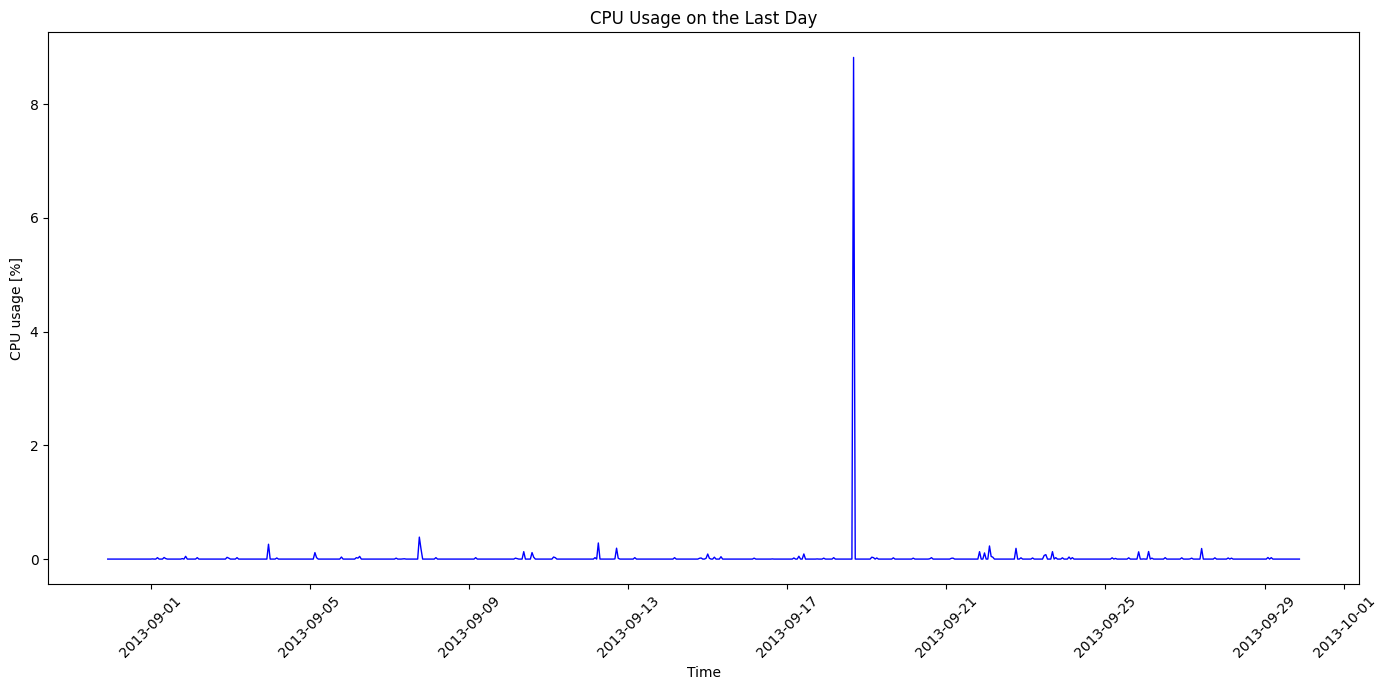

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(cpu_usage_dataset_with_corrected_timestamp['ds'], cpu_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('CPU Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('CPU usage [%]')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    MSTL,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    MSTL(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H',
    fallback_model = SeasonalNaive(season_length=24),
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
crossvaldation_df = sf.cross_validation(
    df=cpu_usage_dataset_with_corrected_timestamp,
    h=168,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,,
VM161,2013-09-22 22:00:00,2013-09-22 21:00:00,0.0,0.0,0.022714,0.022667,0.017264,-0.037161,0.000000,0.026273,0.000000,0.022222
VM161,2013-09-22 23:00:00,2013-09-22 21:00:00,0.0,0.0,0.022741,0.022667,0.117659,-0.021274,0.108333,0.026273,0.108333,0.022222
VM161,2013-09-23 00:00:00,2013-09-22 21:00:00,0.0,0.0,0.022768,0.022667,0.016650,-0.034828,0.000000,0.026273,0.000000,0.022222
VM161,2013-09-23 01:00:00,2013-09-22 21:00:00,0.0,0.0,0.022795,0.022667,0.004185,-0.037463,0.000000,0.026273,0.000000,0.022222
VM161,2013-09-23 02:00:00,2013-09-22 21:00:00,0.0,0.0,0.022822,0.022667,-0.014959,-0.000618,0.230556,0.026273,0.230556,0.022222
...,...,...,...,...,...,...,...,...,...,...,...,...
VM161,2013-09-29 17:00:00,2013-09-22 21:00:00,0.0,0.0,0.027092,0.022667,0.062935,-0.031062,0.000000,0.026273,0.000000,0.022222
VM161,2013-09-29 18:00:00,2013-09-22 21:00:00,0.0,0.0,0.027119,0.022667,0.228687,-0.000447,0.188889,0.026273,0.188889,0.022222
VM161,2013-09-29 19:00:00,2013-09-22 21:00:00,0.0,0.0,0.027146,0.022667,0.119453,-0.030182,0.000000,0.026273,0.000000,0.022222


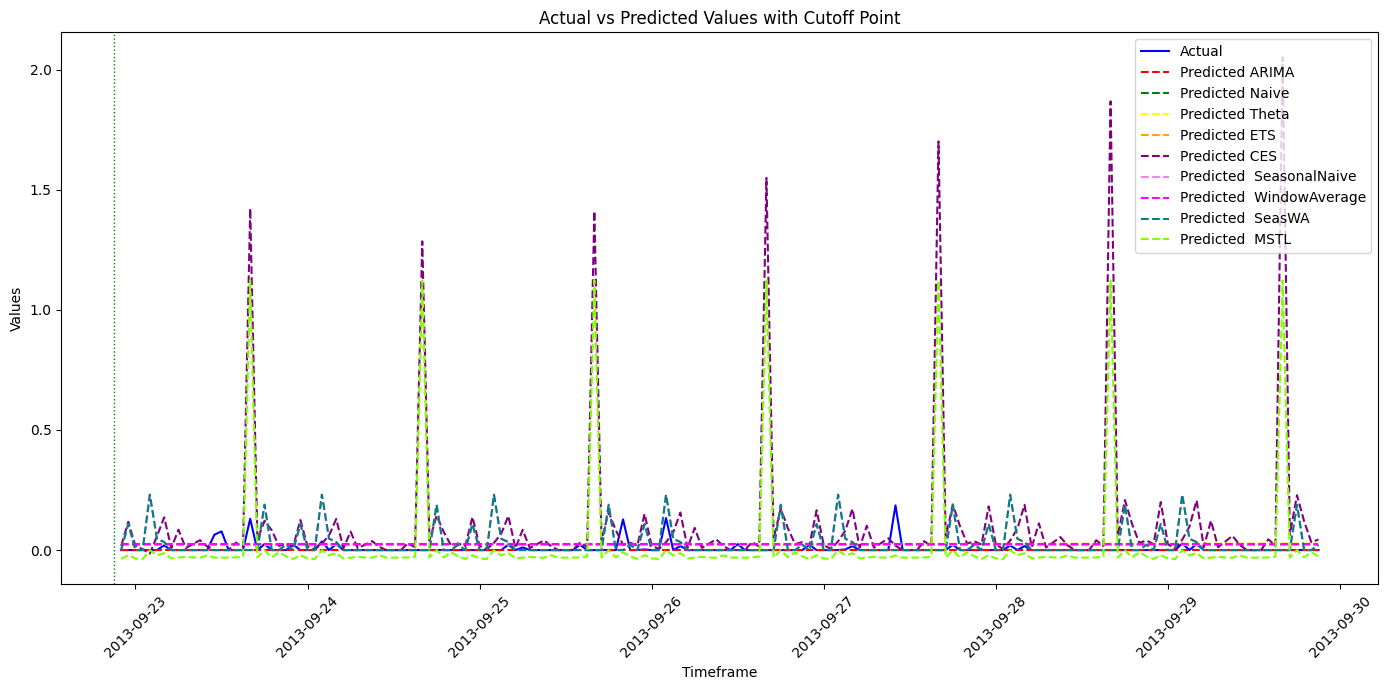

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted  MSTL', color='chartreuse', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(cpu_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
import math

df['date'] = cpu_usage_dataset_with_corrected_timestamp['ds'].dt.date
df['hour'] = cpu_usage_dataset_with_corrected_timestamp['ds'].dt.hour

daily_hours = df.groupby('date')['hour'].nunique()
daily_fraction = daily_hours / 24
total_days = daily_fraction.sum()
total_days_rounded_down = math.floor(total_days * 10) / 10

horizon = 7
initial = total_days_rounded_down - horizon -1
prophet_horizon = str(horizon) + ' days'
prophet_initial = str(initial) + ' days'

prophet_initial

'22.0 days'

In [11]:
df_cv = cross_validation(model, horizon=prophet_horizon,  initial=prophet_initial)

  0%|          | 0/1 [00:00<?, ?it/s]

12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-09-22 22:00:00,0.051616,-0.416195,0.516648,0.0,2013-09-22 21:00:00
1,2013-09-22 23:00:00,0.056776,-0.463626,0.525478,0.0,2013-09-22 21:00:00
2,2013-09-23 00:00:00,0.040339,-0.446524,0.542069,0.0,2013-09-22 21:00:00
3,2013-09-23 01:00:00,0.026043,-0.461467,0.481851,0.0,2013-09-22 21:00:00
4,2013-09-23 02:00:00,0.032302,-0.439335,0.539506,0.0,2013-09-22 21:00:00
...,...,...,...,...,...,...
163,2013-09-29 17:00:00,0.172060,-0.314748,0.619935,0.0,2013-09-22 21:00:00
164,2013-09-29 18:00:00,0.105587,-0.392639,0.560886,0.0,2013-09-22 21:00:00
165,2013-09-29 19:00:00,0.045549,-0.422060,0.535670,0.0,2013-09-22 21:00:00
166,2013-09-29 20:00:00,0.028012,-0.433421,0.503535,0.0,2013-09-22 21:00:00


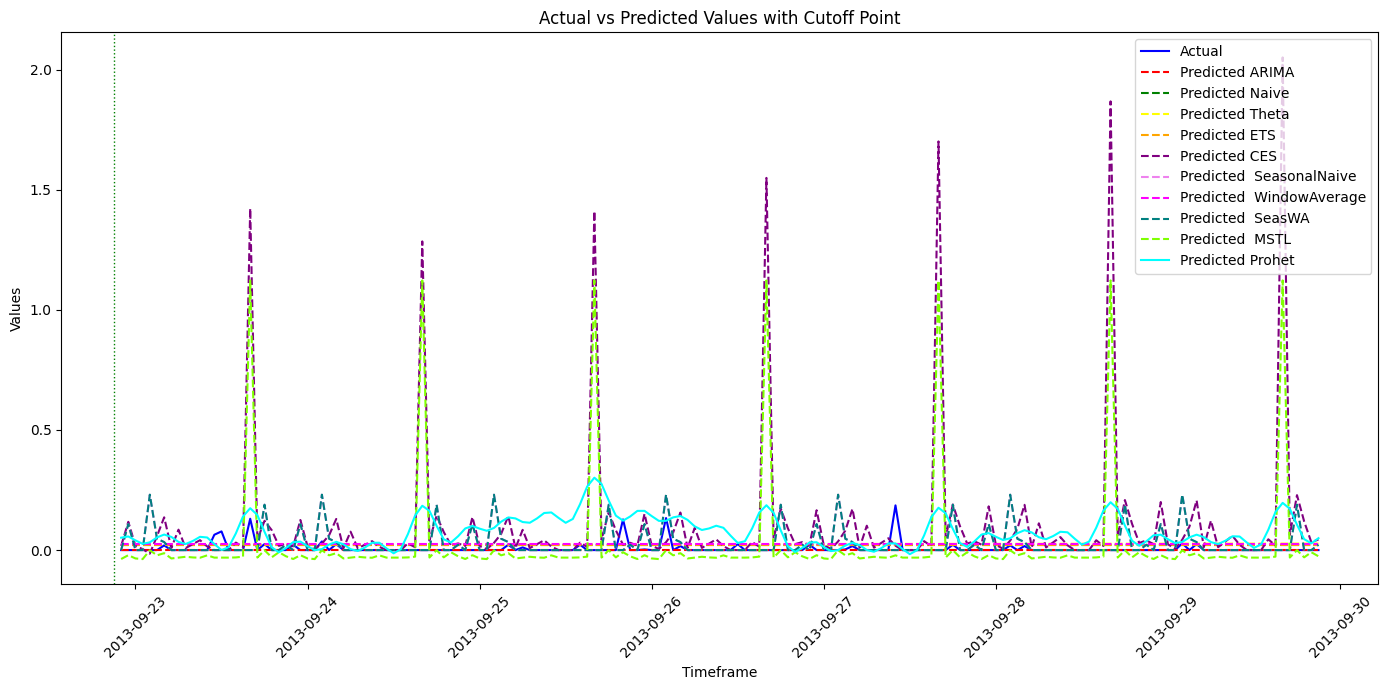

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted  MSTL', color='chartreuse', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [14]:
pd.set_option('display.max_rows', 168)
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,VM161,2013-09-22 22:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022714,0.022667,0.017264,-0.037161,0.000000,0.026273,0.000000,0.022222,0.051616
1,VM161,2013-09-22 23:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022741,0.022667,0.117659,-0.021274,0.108333,0.026273,0.108333,0.022222,0.056776
2,VM161,2013-09-23 00:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022768,0.022667,0.016650,-0.034828,0.000000,0.026273,0.000000,0.022222,0.040339
3,VM161,2013-09-23 01:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022795,0.022667,0.004185,-0.037463,0.000000,0.026273,0.000000,0.022222,0.026043
4,VM161,2013-09-23 02:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022822,0.022667,-0.014959,-0.000618,0.230556,0.026273,0.230556,0.022222,0.032302
5,VM161,2013-09-23 03:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022849,0.022667,0.058032,-0.021895,0.047222,0.026273,0.047222,0.022222,0.052742
6,VM161,2013-09-23 04:00:00,2013-09-22 21:00:00,0.019444,0.0,0.022875,0.022667,0.136377,-0.012824,0.033333,0.026273,0.033333,0.022222,0.064657
7,VM161,2013-09-23 05:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022902,0.022667,0.008336,-0.034840,0.000000,0.026273,0.000000,0.022222,0.054771
8,VM161,2013-09-23 06:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022929,0.022667,0.084984,-0.031146,0.000000,0.026273,0.000000,0.022222,0.034024
9,VM161,2013-09-23 07:00:00,2013-09-22 21:00:00,0.000000,0.0,0.022956,0.022667,0.008416,-0.027858,0.000000,0.026273,0.000000,0.022222,0.025405


In [15]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [16]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,,
VM161,0.000623,0.000927,0.00084,0.113849,0.052302,0.004211,0.000969,0.004211,0.000826,0.0088,AutoARIMA
